<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/preprocessing/voice-analysis.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/preprocessing/voice-analysis.ipynb)

# Analyzing Vocal Features for Pathology

This notebook goes through a simple voice analysis of a few speech samples. First we download a public Parkinson's dataset and cut to just the sustained phonation.

In [1]:
%%capture
!wget -O BL01_ENSS.wav "https://data.mendeley.com/public-files/datasets/9dz247gnyb/files/5183cb8f-77ff-418d-a4cc-e2eca48cb6a5/file_downloaded"
!ffmpeg -ss 18 -t 3.5 -y -i BL01_ENSS.wav phonation.wav

In [2]:
%%capture
import torch
import torchaudio
import matplotlib.pyplot as plt
from speechbrain.processing.voice_analysis import *

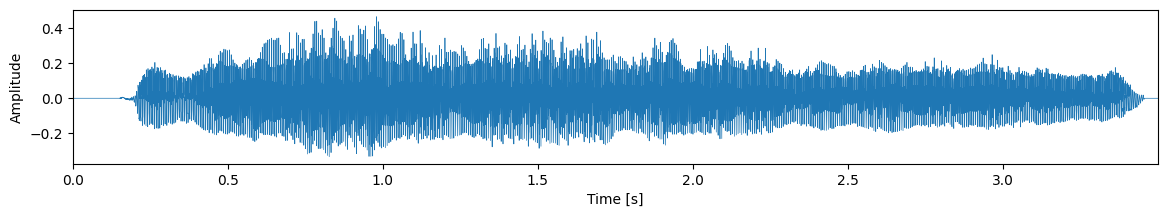

In [3]:
# Load sustained phonation recording from QPN dataset
audio_filename = "phonation.wav"
audio, sample_rate = torchaudio.load(audio_filename)

# Parameters for all figures in the document
plt.rcParams["figure.figsize"] = (14,2)
plt.rcParams['axes.xmargin'] = 0

# Downsample to reduce number of points on the plot
downsample_factor = 20
xs = torch.arange(len(audio[0,::downsample_factor])) / sample_rate * downsample_factor
plt.plot(xs, audio[0,::downsample_factor], linewidth=.5)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Intro

To understand how this speech analysis works, we'll step through the `vocal_characteristics` function. The very fist lines
just set up the variables needed for computation

In [4]:
# Frequency of human speech is usually between 75-300 Hz
min_f0_Hz = 75
max_f0_Hz = 300

# A new window of 0.04 second length every 0.01 seconds
step_size = 0.01
window_size = 0.04

# Do some number manipulations
step_samples = int(step_size * sample_rate)
window_samples = int(window_size * sample_rate)
max_lag = int(sample_rate / min_f0_Hz)
min_lag = int(sample_rate / max_f0_Hz)

print("Samples between (the start of) one frame and the next:", step_samples)
print("Samples contained within each frame:", window_samples)
print("Number of samples in the maximum lag:", max_lag)
print("Number of samples in the minimum lag:", min_lag)

Samples between (the start of) one frame and the next: 441
Samples contained within each frame: 1764
Number of samples in the maximum lag: 588
Number of samples in the minimum lag: 147


Our sanity check for these values is that at least one complete period will be contained in the frame (for minimum Hz) and at most 8 for maximum Hz.

## Getting voiced portion

In order to do a f0 analysis, we have to figure out which portions are harmonic. We use both autocorrelation and jitter (as in PRAAT).

Autocorrelation is the cross-correlation of a signal with itself at various lags.
For harmonic signals, there are peaks at regular intervals corresponding to the period.
The autocorrelation ratio is the ratio of the strongest peak against the theoretical maximum
which occurs when the lag is zero.

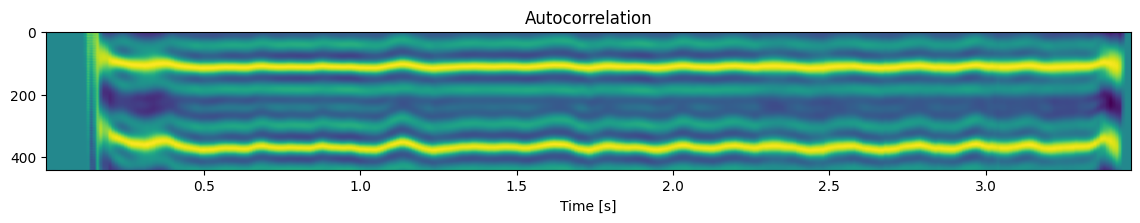

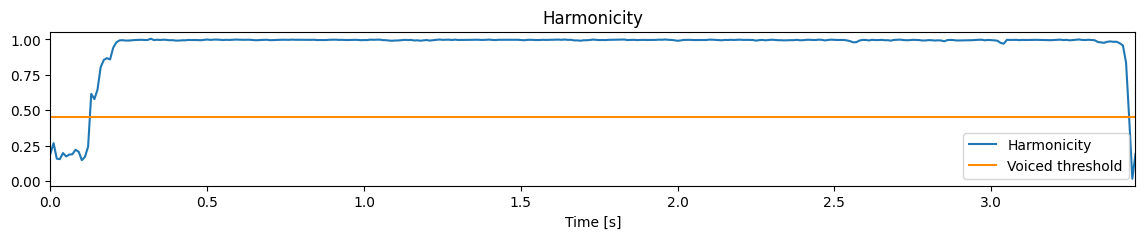

In [5]:
import matplotlib.ticker as ticker

# Split into frames, and compute autocorrelation for each frame
frames = audio.unfold(-1, window_samples, step_samples)
autocorrelation = autocorrelate(frames)

# Use autocorrelation to estimate harmonicity and best lags
harmonicity, lags = autocorrelation[:, :, min_lag:max_lag].max(dim=-1)
lags = torch.nn.functional.pad(lags, pad=(3, 3)) 
best_lags, _ = lags.unfold(-1, 7, 1).median(dim=-1)

# Re-add the min_lag back in after previous step removed it
best_lags = best_lags + min_lag

harmonicity_threshold = 0.45

xs = torch.arange(len(harmonicity[0])) * step_size


plt.imshow(autocorrelation[0, :, min_lag:max_lag].transpose(0,1), aspect=0.1)
plt.title('Autocorrelation')
plt.xlabel("Time [s]")
xticks = (torch.arange(1, 7) / 2 / step_size).int().tolist()
plt.xticks(xticks, xs[xticks].tolist())
plt.show()

plt.plot(xs, harmonicity[0])
plt.title("Harmonicity")
plt.xlabel("Time [s]")
plt.axhline(y = harmonicity_threshold, color="darkorange")
plt.legend(["Harmonicity", "Voiced threshold"])
plt.show()

PRAAT uses jitter to compute a voicing decision as well, using a cutoff of 0.02. We do a similar process here.

A fuller description of the periodic features is further on in this notebook, for now a simple explanation is that they measure variations across periods.

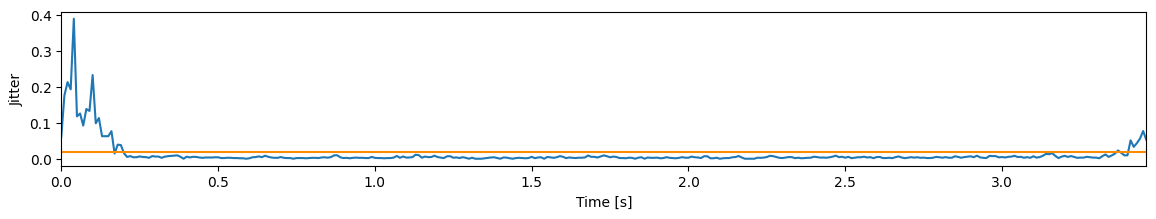

In [6]:
jitter, shimmer = compute_periodic_features(frames, best_lags)

jitter_threshold = 0.02
plt.plot(xs, jitter[0])
plt.xlabel("Time [s]")
plt.ylabel("Jitter")
plt.axhline(y = jitter_threshold, color="darkorange")
plt.show()

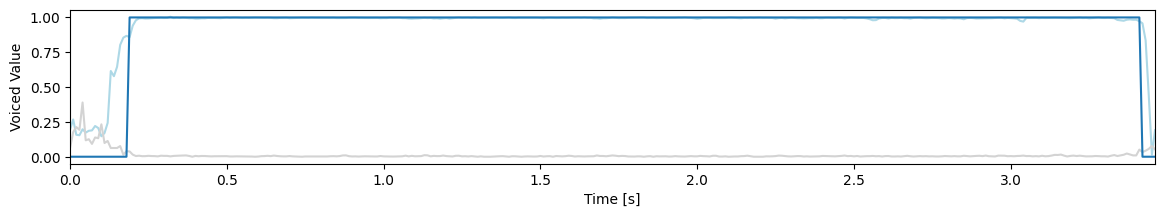

In [7]:
# voicing threshold is simply the intersection of these thresholds
voiced = harmonicity > harmonicity_threshold
voiced &= jitter < jitter_threshold

# We don't want voicing decisions to change too rapidly, use an average to smooth
voiced = neighbor_average(voiced, 19).round().bool()

plt.plot(xs, harmonicity[0], color="lightblue")
plt.plot(xs, jitter[0], color="lightgray")
plt.plot(xs, voiced[0])
plt.xlabel("Time [s]")
plt.ylabel("Voiced Value")
plt.show()

In [8]:
print("Total frame count:", len(voiced[0]))
print("Voiced frame count:", voiced.sum().numpy())

Total frame count: 347
Voiced frame count: 323


## Computing f0

The fundamental frequency, f0, is the period of the waveform. This is computed by taking the
k-best lags from the autocorrelation and comparing to neighboring frames to avoid octave errors.

Estimated average frequency: 171.9 Hz


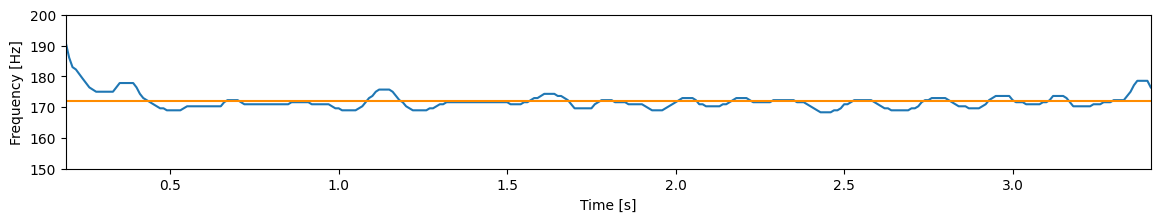

In [9]:
# Frequency is 1 / period-slash-lag
estimated_f0 = sample_rate / best_lags

plt.plot(xs[voiced[0]], estimated_f0[voiced])
plt.ylim((150, 200))
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.axhline(y = estimated_f0[voiced].mean(), color="darkorange")
print("Estimated average frequency: {0:.1f} Hz".format(estimated_f0[voiced].mean().numpy()))

## Computing vocal characteristics

Common vocal characteristics are jitter, shimmer, and harmonic-to-noise ratio. Let's visualize using the frame #200.

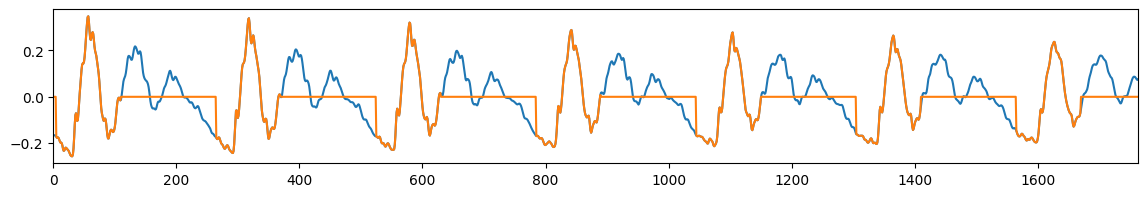

In [10]:
frame_i = 173
plt.plot(frames[0, frame_i])

# Prepare for masking
masked_frames = torch.clone(frames).detach()
mask_indices = torch.arange(frames.size(-1)).view(1, 1, -1)
mask_indices = mask_indices.expand(frames.shape)
periods = best_lags.unsqueeze(-1)
period_indices = mask_indices.remainder(periods)

# Mask everything not within about 20% (1/5) of a period peak
jitter_range = periods // 5
peak, lag = torch.max(masked_frames, dim=-1, keepdim=True)
mask = (
    (period_indices < lag.remainder(periods) - jitter_range)
    | (period_indices > lag.remainder(periods) + jitter_range)
)
masked_frames[mask] = 0


plt.plot(masked_frames[0, frame_i])

tensor([ 437,  181, 1204,  693,  948])


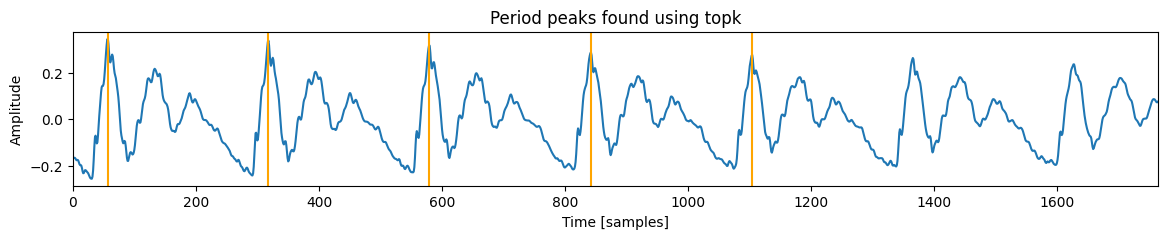

In [11]:
plt.plot(frames[0, frame_i])
peaks, lags = [], []

# Find neighboring peaks
peaks, lags = [], []
for i in range(5):
    peak, lag = torch.max(masked_frames, dim=-1, keepdim=True)
    mask = (
        (mask_indices > lag - periods // 2)
        & (mask_indices < lag + periods // 2)
    )
    masked_frames[mask] = 0
    peaks.append(peak.squeeze(-1))
    lags.append(lag.squeeze(-1))

peaks = torch.stack(peaks, dim=-1)
lags = torch.stack(lags, dim=-1)

for lag in lags[0, frame_i]:
    plt.axvline(lag, color="orange")

plt.title("Period peaks found using topk")
plt.xlabel("Time [samples]")
plt.ylabel("Amplitude")
print(lags[0, 230])

In [12]:
# Jitter = average variation in period length
# Compute mean difference from mean lag, normalized by period
lags = lags.remainder(periods)
jitter_frames = (lags - lags.float().mean(dim=-1, keepdims=True)).abs()
jitter = jitter_frames.mean(dim=-1) / best_lags

print(lags[0, frame_i])
print(jitter_frames[0, frame_i] / best_lags[0, frame_i])
print(jitter[0, frame_i])

tensor([57, 58, 59, 62, 64])
tensor([0.0115, 0.0077, 0.0038, 0.0077, 0.0154])
tensor(0.0092)


Average Jitter: 0.43%


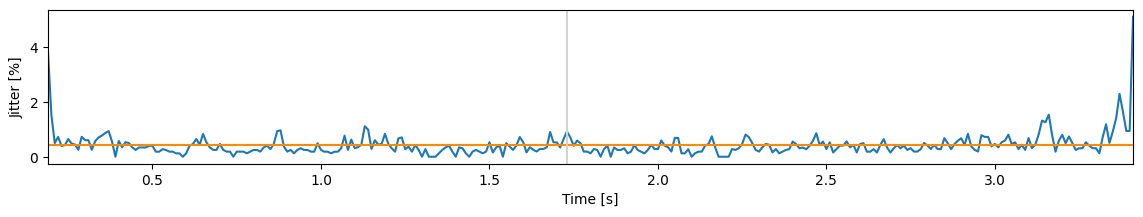

In [13]:
plt.plot(xs[voiced[0]], jitter[voiced] * 100)
plt.xlabel("Time [s]")
plt.ylabel("Jitter [%]")
plt.axhline(y = jitter[voiced].mean() * 100, color="darkorange")
plt.axvline(x = frame_i / 100, color="lightgrey")
print("Average Jitter: {0:.2f}%".format(100 * jitter[voiced].mean().numpy()))

In [14]:
# Shimmer = average variation in amplitude, normalized by avg amplitude
avg_amps = peaks.mean(dim=-1, keepdims=True)
amp_diff = (peaks - avg_amps).abs()
shimmer = amp_diff.mean(dim=-1) / avg_amps.squeeze(-1).clamp(min=1e-3)

print(amp_diff[0, frame_i] / avg_amps[0, frame_i])
print(shimmer[0, frame_i])

tensor([0.1043, 0.0781, 0.0180, 0.0833, 0.1171])
tensor(0.0801)


Average Shimmer: 4.71%


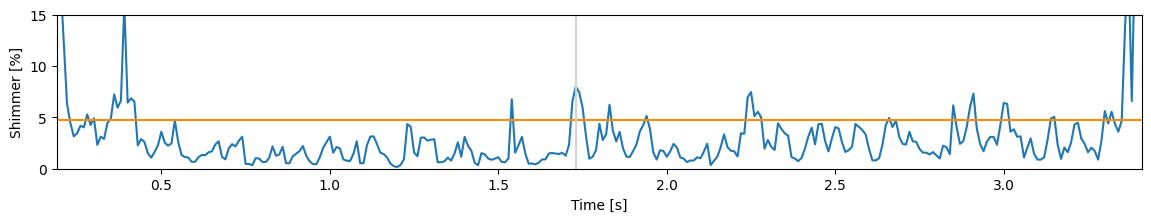

In [15]:

plt.plot(xs[voiced[0]], shimmer[voiced] * 100)
plt.xlabel("Time [s]")
plt.ylabel("Shimmer [%]")
plt.ylim((0, 15))
plt.axhline(y = shimmer.mean() * 100, color="darkorange")
plt.axvline(x = frame_i / 100, color="lightgrey")
print("Average Shimmer: {0:.2f}%".format(100 * shimmer.mean().numpy()))

Average HNR: 22.81


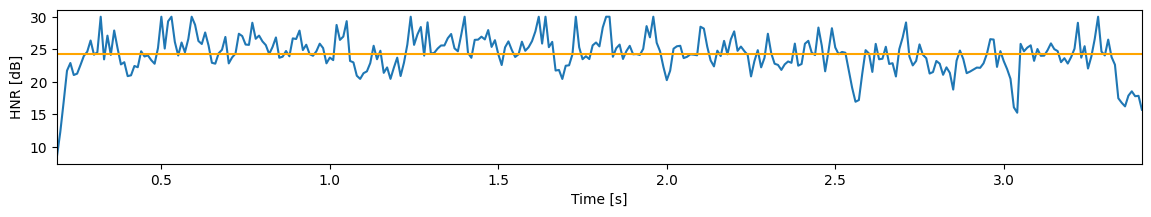

In [16]:
# Autocorrelation is the measure of harmonicity here, 1-harmonicity is noise
# See "Harmonic to Noise Ratio Measurement - Selection of Window and Length"
# By J. Fernandez, F. Teixeira, V. Guedes, A. Junior, and J. P. Teixeira
# Term is dominated by denominator, so just take -1 * log(noise)
# max value for harmonicity is 25 dB, enforced by this minimum here
noise = torch.clamp(1 - harmonicity, min=10**-3)
hnr = -10 * torch.log10(noise)


plt.plot(xs[voiced[0]], hnr[voiced])
plt.xlabel("Time [s]")
plt.ylabel("HNR [dB]")
plt.axhline(y = hnr[voiced].mean(), color="orange")
print("Average HNR: {0:.2f}".format(hnr.mean().numpy()))

## Compute GNE step-by-step

The algorithm is best described in "The Effectiveness of the Glottal to Noise Excitation Ratio for the Screening of Voice Disorders" by Godino-Llorente et al.


In [17]:
# Step 1. Downsample to 10 kHz since voice energy is low above 5 kHz
new_sample_rate = 10000
downsampled_audio = torchaudio.functional.resample(audio, 44100, new_sample_rate)

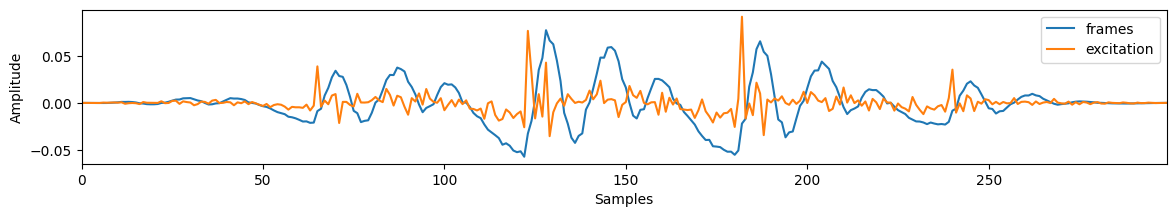

In [18]:
# Step 2. Inverse filter with 30-msec window, 10-msec hop and 13th order LPC
frame_size, hop_size, lpc_order = 300, 100, 13

# Solve for LPC coefficients
window = torch.hann_window(frame_size).view(1, 1, -1)
frames = downsampled_audio.view(1, -1).unfold(-1, frame_size, hop_size) * window

autocorrelation = compute_cross_correlation(frames, frames, width=lpc_order)

# Collapse frame and batch into same dimension, for lfiltering
batch, frame_count, _ = autocorrelation.shape
autocorrelation = autocorrelation.view(batch * frame_count, -1)

# Construct Toeplitz matrices (one per frame)
# This is [[p0, p1, p2...], [p1, p0, p1...], [p2, p1, p0...] ...]
# Our sliding window should go from the end to the front, so flip
# The autocorrelation has an extra value on each end for our prediction values
R = autocorrelation[:, 1: -1].unfold(-1, lpc_order, 1).flip(dims=(1,))
r = autocorrelation[:, lpc_order + 1:]

# Solve for LPC coefficients, generate inverse filter with coeffs 1, -a_1, ...
lpc = torch.linalg.solve(R, r)
a_coeffs = torch.cat((torch.ones(lpc.size(0), 1), -lpc), dim=1)
b_coeffs = torch.zeros_like(a_coeffs)
b_coeffs[:, 0] = 1

# Perform filtering
excitation = torchaudio.functional.lfilter(frames, b_coeffs, a_coeffs, clamp=False)
plt.plot(frames[0, 200, :] * 0.3, label='frames')
plt.plot(excitation[0, 200, :], label='excitation')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

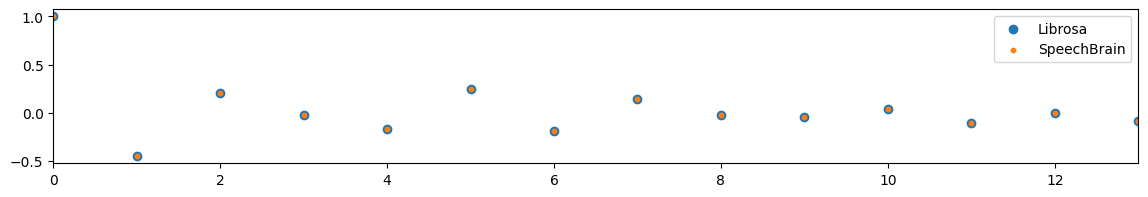

In [19]:
# Compare cf. librosa to check accuracy
import librosa

librosa_coeffs = librosa.lpc(frames[0, 0].numpy(), order=lpc_order)
plt.scatter(torch.arange(lpc_order + 1), librosa_coeffs)
plt.scatter(torch.arange(lpc_order + 1), a_coeffs[0], s=10)
plt.legend(["Librosa", "SpeechBrain"])
plt.show()

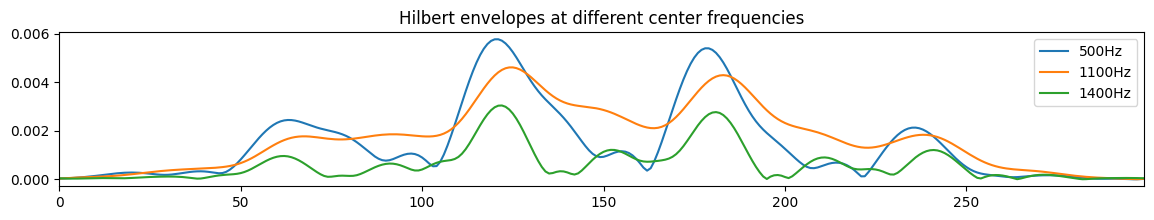

In [20]:
# Step 3. Compute Hilbert envelopes for each frequency bin
bandwidth = 1000
fshift = 300
min_freq, max_freq = bandwidth // 2, new_sample_rate // 2 - bandwidth // 2
center_freqs = range(min_freq, max_freq, fshift)
envelopes = {
    center_freq: compute_hilbert_envelopes(
        excitation, center_freq, bandwidth, new_sample_rate
    )
    for center_freq in center_freqs
}
plt.plot(envelopes[500][0, 200])
plt.plot(envelopes[1100][0, 200])
plt.plot(envelopes[1400][0, 200])
plt.legend(["500Hz", "1100Hz", "1400Hz"])
plt.title("Hilbert envelopes at different center frequencies")
plt.show()

In [21]:
# Step 4. Compute cross correlation between (non-neighboring) frequency bins
correlations = [
    compute_cross_correlation(envelopes[freq_i], envelopes[freq_j], width=3)
    for freq_i in center_freqs
    for freq_j in center_freqs
    if (freq_j - freq_i) > bandwidth // 2
]

# Step 5. The maximum cross-correlation is the GNE score
gne = torch.stack(correlations, dim=-1).amax(dim=(2, 3))
gne = -10 * torch.log10(1 - gne)

tensor(19.9699)


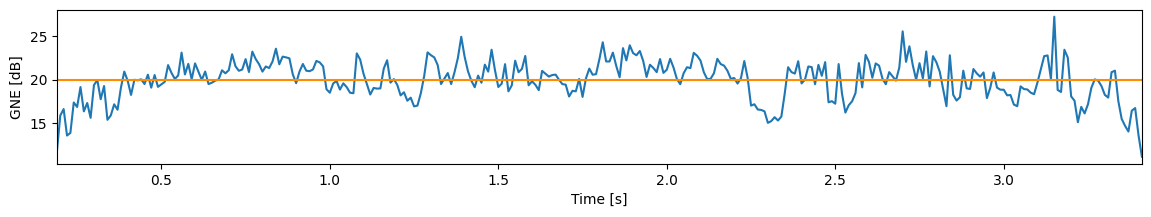

In [22]:
gne = gne[:, :voiced.size(1)]
new_step_size = hop_size / new_sample_rate
gne_xs = torch.arange(len(gne[0])) * new_step_size
plt.plot(gne_xs[voiced[0]], gne[voiced])
plt.xlabel("Time [s]")
plt.ylabel("GNE [dB]")
plt.axhline(gne[voiced].mean(), color="darkorange")
print(gne[voiced].mean())

## PRAAT-Parselmouth

We'll run a similar analysis to verify that our numbers look accurate.

In [23]:
%%capture
!pip install praat-parselmouth

In [23]:
import parselmouth
from parselmouth.praat import call
import numpy as np

# Bundle these to compute them again later
def compute_praat_features(audio_filename):
    f0min = 75
    f0max = 300
    
    sound = parselmouth.Sound(audio_filename)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    pitch = sound.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan

    jitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

    harmonicity = sound.to_harmonicity()

    return pitch.xs() - 0.02, pitch_values, jitter, shimmer, harmonicity


pitch_xs, pitch_values, praat_jitter, praat_shimmer, praat_harmonicity = compute_praat_features(audio_filename)

Estimated average frequency (SpeechBrain): 171.9 Hz
Estimated average frequency (PRAAT): 171.9 Hz


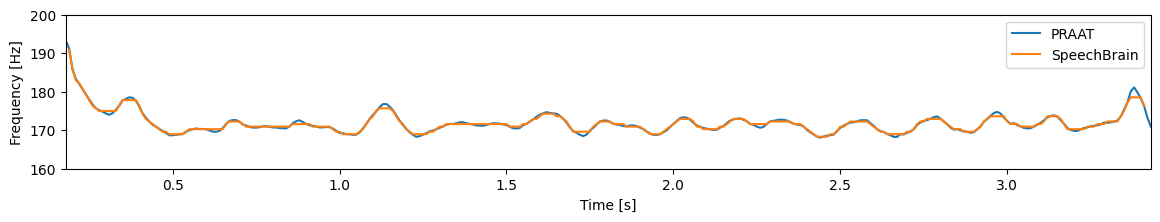

In [24]:
# Pitch comparison
plt.plot(pitch_xs, pitch_values)
plt.plot(xs[voiced[0]], estimated_f0[voiced])
plt.ylim((160, 200))
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.legend(["PRAAT", "SpeechBrain"])

print("Estimated average frequency (SpeechBrain): {0:.1f} Hz".format(estimated_f0[voiced].mean().numpy()))
print("Estimated average frequency (PRAAT): {0:.1f} Hz".format(np.nanmean(pitch_values)))

In [25]:
print("Average Jitter (SpeechBrain): {0:.2f}%".format(100 * jitter[voiced].mean().numpy()))
print("Average Jitter (PRAAT): {0:.2f}%".format(100 * praat_jitter))

Average Jitter (SpeechBrain): 0.43%
Average Jitter (PRAAT): 0.35%


In [26]:
print("Average Shimmer (SpeechBrain): {0:.2f}%".format(100 * shimmer[voiced].mean().numpy()))
print("Average Shimmer (PRAAT): {0:.2f}%".format(100 * praat_shimmer))

Average Shimmer (SpeechBrain): 3.08%
Average Shimmer (PRAAT): 0.85%


Average HNR (SpeechBrain): 24.3%
Average HNR (PRAAT): 27.3%


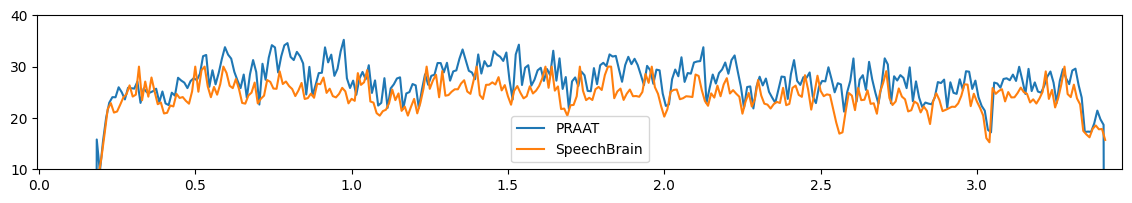

In [27]:
praat_hnr = call(praat_harmonicity, "Get mean", 0, 0)
plt.plot(praat_harmonicity.xs() - 0.02, praat_harmonicity.values.T)
plt.plot(xs[voiced[0]], hnr[voiced])
plt.ylim((10, 40))
plt.legend(["PRAAT", "SpeechBrain"])
print("Average HNR (SpeechBrain): {0:.1f}%".format(hnr[voiced].mean().numpy()))
print("Average HNR (PRAAT): {0:.1f}%".format(praat_hnr))

## Comparison with OpenSMILE

Unlike PRAAT, we can do a frame-by-frame comparison with OpenSMILE.

In [28]:
%%capture
!pip install opensmile

In [29]:
import opensmile

opensmile_extractor = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

opensmile_feats = opensmile_extractor.process_file(audio_filename)
opensmile_feats.shape

(346, 25)

In [30]:
opensmile_feats.columns

Index(['Loudness_sma3', 'alphaRatio_sma3', 'hammarbergIndex_sma3',
       'slope0-500_sma3', 'slope500-1500_sma3', 'spectralFlux_sma3',
       'mfcc1_sma3', 'mfcc2_sma3', 'mfcc3_sma3', 'mfcc4_sma3',
       'F0semitoneFrom27.5Hz_sma3nz', 'jitterLocal_sma3nz',
       'shimmerLocaldB_sma3nz', 'HNRdBACF_sma3nz', 'logRelF0-H1-H2_sma3nz',
       'logRelF0-H1-A3_sma3nz', 'F1frequency_sma3nz', 'F1bandwidth_sma3nz',
       'F1amplitudeLogRelF0_sma3nz', 'F2frequency_sma3nz',
       'F2bandwidth_sma3nz', 'F2amplitudeLogRelF0_sma3nz',
       'F3frequency_sma3nz', 'F3bandwidth_sma3nz',
       'F3amplitudeLogRelF0_sma3nz'],
      dtype='object')

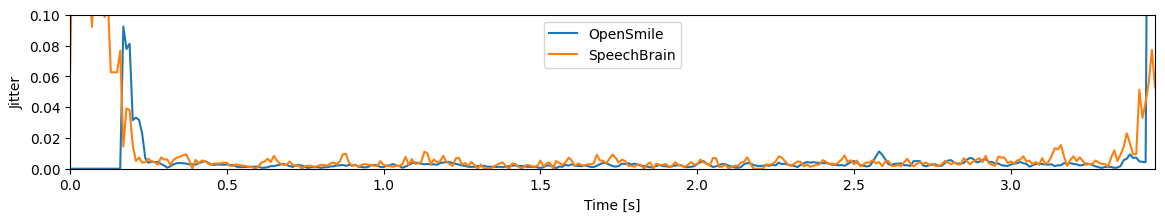

In [31]:
os_xs = opensmile_feats.index.get_level_values("start").total_seconds()
plt.plot(os_xs, opensmile_feats.jitterLocal_sma3nz)
plt.plot(xs, jitter[0])
plt.ylim((0, 0.1))
plt.xlabel("Time [s]")
plt.ylabel("Jitter")
plt.legend(["OpenSmile", "SpeechBrain"])

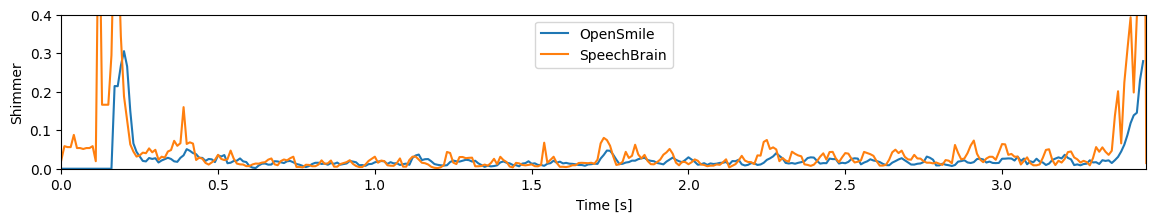

In [32]:
# From the name, it looks like shimmer should be in dB but the curve does not look it. Dividing by 10 is roughly the same.
plt.plot(os_xs, opensmile_feats.shimmerLocaldB_sma3nz / 10)
plt.plot(xs, shimmer[0])
plt.ylim((0, 0.4))
plt.xlabel("Time [s]")
plt.ylabel("Shimmer")
plt.legend(["OpenSmile", "SpeechBrain"])

12.219974517822266


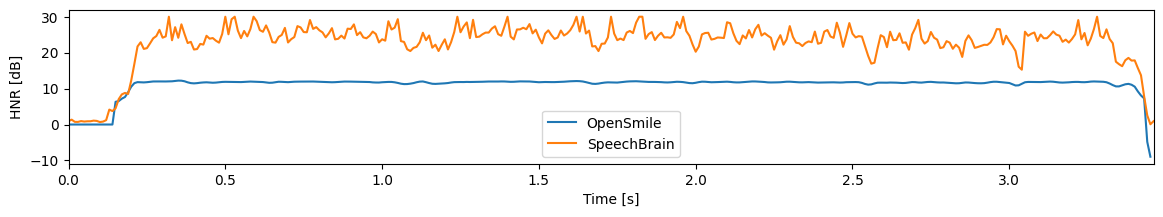

In [33]:
# Looks like there's a cap of ~12.5 dB for the openSmile features
plt.plot(os_xs, opensmile_feats.HNRdBACF_sma3nz)
plt.plot(xs, hnr[0])
plt.xlabel("Time [s]")
plt.ylabel("HNR [dB]")
plt.legend(["OpenSmile", "SpeechBrain"])
print(max(opensmile_feats.HNRdBACF_sma3nz))

## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```